## Реализация обхода в ширину из нескольких стартовых вершин (Multiple-Source BFS)

In [1]:
import graphblas as gb

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector, Scalar
from graphblas.io import mmread
import numpy as np
import time
import timeit
from functools import partial
import pandas as pd
import random
import time
import os
import matplotlib.pyplot as plt

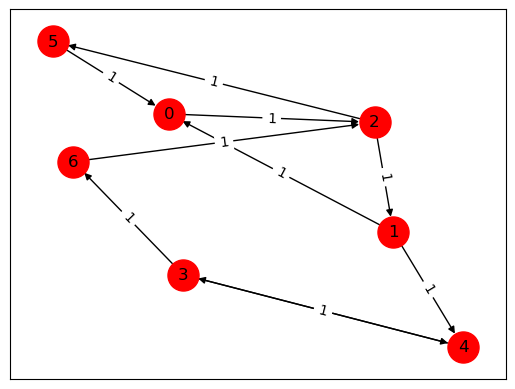

In [2]:
edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
]

A = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [3]:
def calculate_msbfs_levels(graph, start_points, semiring=semiring.lor_land):
    level_results = []
    total_nodes = graph.nrows

    if not isinstance(start_points, list):
        start_points = [start_points]

    for point in start_points:
        level_vector = Vector(dtypes.INT32, total_nodes)
        visited = Vector(bool, total_nodes)
        visited[point] << True
        is_successor = Scalar(bool)
        current_level = 0

        for _ in range(total_nodes):
            level_vector(mask=visited.V) << current_level
            current_level += 1
            visited(~level_vector.S, replace=True) << visited.vxm(graph, semiring)

        level_vector(~level_vector.S) << -1
        node_levels = [(i, level_vector.get(i, default=-1)) for i in range(total_nodes)]
        level_results.append((point, node_levels))

    return level_results

In [4]:
calculate_msbfs_levels(A, [1, 6])

[(1, [(0, 1), (1, 0), (2, 2), (3, 2), (4, 1), (5, 3), (6, 3)]),
 (6, [(0, 3), (1, 2), (2, 1), (3, 4), (4, 3), (5, 2), (6, 0)])]

In [5]:
calculate_msbfs_levels(A, 5)

[(5, [(0, 1), (1, 3), (2, 2), (3, 5), (4, 4), (5, 0), (6, 6)])]

In [6]:
def find_parents_msbfs(matrix, start_points, semiring=semiring.min_first):
    results_list = []
    total_nodes = matrix.nrows
    if not isinstance(start_points, list):
        start_points = [start_points]
    for start in start_points:
        node_indices = Vector(dtypes.INT32, total_nodes)
        node_indices.build(range(total_nodes), range(total_nodes))
        parent_nodes = Vector(dtypes.INT32, total_nodes)
        parent_nodes[start] << -1
        current_wave = Vector(dtypes.INT32, total_nodes)
        current_wave[start] << -1
        while current_wave.nvals > 0:
            current_wave << node_indices.ewise_mult(current_wave, binary.first)
            current_wave(~parent_nodes.S, replace=True) << current_wave.vxm(matrix, semiring)
            parent_nodes(binary.plus) << current_wave
        parent_nodes(~parent_nodes.S) << -2
        parent_mapping = [(node, parent_nodes.get(node, default=-1)) for node in range(total_nodes)]
        results_list.append((start, parent_mapping))
    return results_list

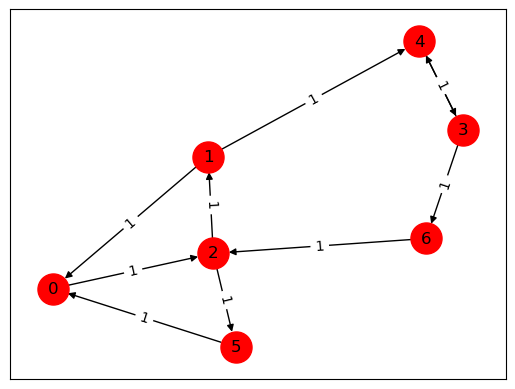

In [7]:
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [8]:
find_parents_msbfs(A, [1, 6])

[(1, [(0, 1), (1, -1), (2, 0), (3, 4), (4, 1), (5, 2), (6, 3)]),
 (6, [(0, 1), (1, 2), (2, 6), (3, 4), (4, 1), (5, 2), (6, -1)])]

In [9]:
find_parents_msbfs(A, 5)

[(5, [(0, 5), (1, 2), (2, 0), (3, 4), (4, 1), (5, -1), (6, 3)])]

In [10]:


def test_calculate_msbfs_levels():
    edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))

    # Тест 1: Проверка уровней для одной стартовой точки
    result = calculate_msbfs_levels(graph, [0])
    assert result == [(0, [(0, 0), (1, 2), (2, 1), (3, 4), (4, 3), (5, 2), (6, 5)])]

    # Тест 2: Проверка уровней для нескольких стартовых точек
    result = calculate_msbfs_levels(graph, [0, 3])
    assert result == [
        (0, [(0, 0), (1, 2), (2, 1), (3, 4), (4, 3), (5, 2), (6, 5)]),
     (3, [(0, 4), (1, 3), (2, 2), (3, 0), (4, 1), (5, 3), (6, 1)])
     ]

    # Тест 3: Граф с изолированными узлами
    edges = [
        [0, 1],
        [1, 0],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]), nrows=4, ncols=4)
    result = calculate_msbfs_levels(graph, [0])
    assert result == [(0, [(0, 0), (1, 1), (2, -1), (3, -1)])]
    print("Успешно!")
     

def test_find_parents_msbfs():
    edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))

    # Тест 1: Проверка поиска родителей для одной стартовой точки
    result = find_parents_msbfs(graph, [0])
    assert result == [(0, [(0, -1), (1, 2), (2, 0), (3, 4), (4, 1), (5, 2), (6, 3)])]

    # Тест 2: Проверка поиска родителей для нескольких стартовых точек
    result = find_parents_msbfs(graph, [0, 3])
    assert result == [
        (0, [(0, -1), (1, 2), (2, 0), (3, 4), (4, 1), (5, 2), (6, 3)]),
        (3, [(0, 1), (1, 2), (2, 6), (3, -1), (4, 3), (5, 2), (6, 3)])
    ]

    # Тест 3: Граф с изолированными узлами
    edges = [
        [0, 1],
        [1, 0],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]), nrows=4, ncols=4)
    result = find_parents_msbfs(graph, [0])
    assert result == [(0, [(0, -1), (1, 0), (2, -2), (3, -2)])]
    print("Успешно!")
     

test_calculate_msbfs_levels()
test_find_parents_msbfs()
     


Успешно!
Успешно!


In [11]:


def calculate_time(A, start_points):
    start_time = time.time()
    calculate_msbfs_levels(A, start_points)
    level_time = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points)
    parents_time = time.time() - start_time

    return level_time, parents_time
     

results = {}
for i in range (1, 11):
    path = 'data/M' + str(i) + '.mtx'
    M = mmread(path)
    nonzero_count = M.nvals
    times = calculate_time(M, [1,2])
    results[nonzero_count] = times
results = dict(sorted(results.items()))
     


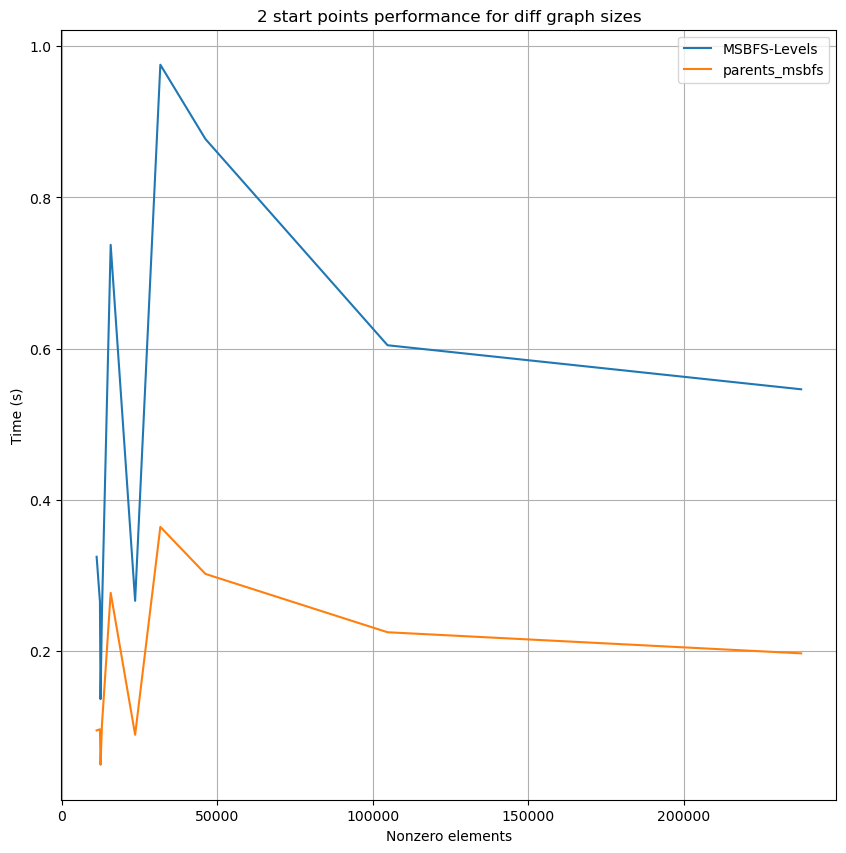

In [12]:
nonzero_count_list = list(results.keys())
level_time = [results[count][0] for count in nonzero_count_list]
parents_time = [results[count][1] for count in nonzero_count_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(nonzero_count_list, level_time, label='MSBFS-Levels')
ax.plot(nonzero_count_list, parents_time, label='parents_msbfs')
ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('2 start points performance for diff graph sizes')
ax.legend()
ax.grid(True)

In [13]:
results = {}
for i in range (1, 11):
    path = 'data/M' + str(i) + '.mtx'
    M = mmread(path)
    nonzero_count = M.nvals
    times = calculate_time(M, [1,2, 3, 4, 5])
    results[nonzero_count] = times
results = dict(sorted(results.items()))

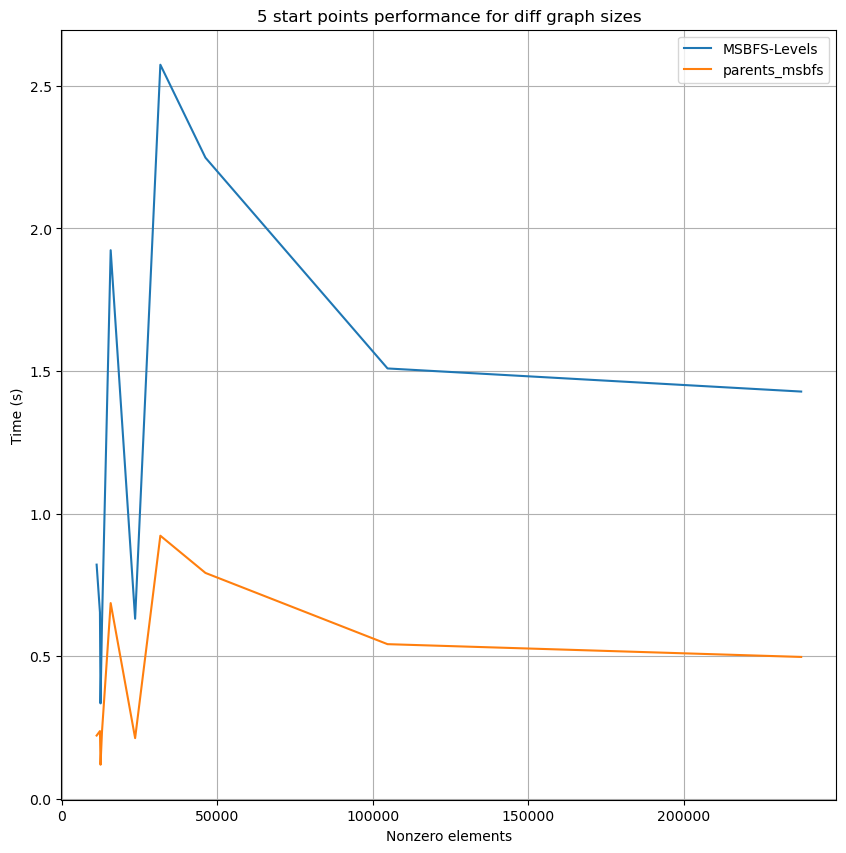

In [14]:
nonzero_count_list = list(results.keys())
level_time = [results[count][0] for count in nonzero_count_list]
parents_time = [results[count][1] for count in nonzero_count_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(nonzero_count_list, level_time, label='MSBFS-Levels')
ax.plot(nonzero_count_list, parents_time, label='parents_msbfs')
ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('5 start points performance for diff graph sizes')
ax.legend()
ax.grid(True)

In [15]:
def generate_random_graph(num_vertices, sparsity):
  np_zeros = np.zeros((num_vertices, num_vertices))
  adjacency_matrix = gb.Matrix.from_dense(np_zeros, missing_value=0)
  for i in range(num_vertices):
      for j in range(i, num_vertices):
          if random.random() < sparsity:
              if i == j:
                  adjacency_matrix[i, j] = 1
              else:
                  adjacency_matrix[i, j] = 1
                  adjacency_matrix[j, i] = 1

  return adjacency_matrix

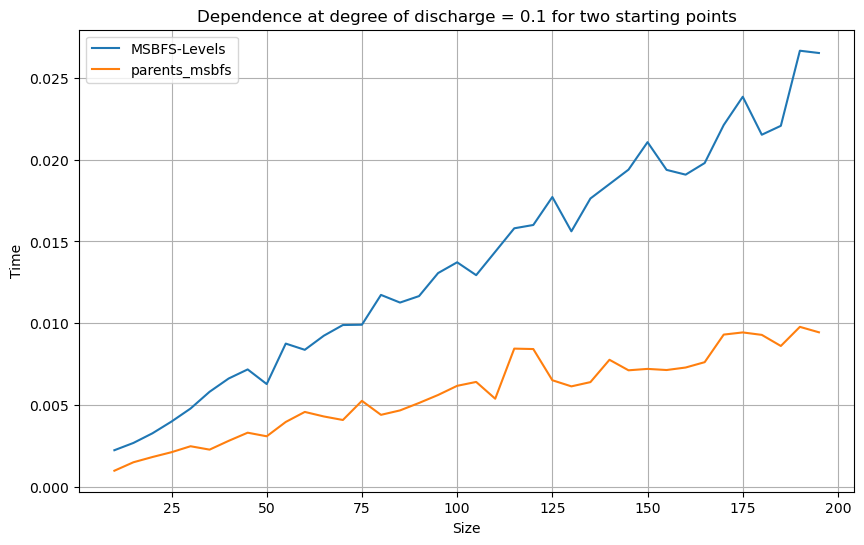

In [16]:
results_random = {}
for num_vertices in np.arange(10, 200, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time = [results_random[count][0] for count in num_vertices_list]
parents_time = [results_random[count][1] for count in num_vertices_list]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time, label='MSBFS-Levels')
ax.plot(num_vertices_list, parents_time, label='parents_msbfs')

ax.set_xlabel('Size')
ax.set_ylabel('Time')
ax.set_title('Dependence at degree of discharge = 0.1 for two starting points')
ax.legend()
ax.grid(True)
plt.show()

Вывод:
1)MSBFS-parents работает немного быстрее MSBFS-levels  
2)При большем количестве стартовых точек оба алгоритма работают медленне

In [17]:
def calculate_time_semiring(A, start_points):
    start_time = time.time()
    calculate_msbfs_levels(A, start_points)
    level_time_any_pair = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points)
    parents_time_min_first = time.time() - start_time

    start_time = time.time()
    calculate_msbfs_levels(A, start_points, semiring.min_first)
    level_time_min_first = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points, semiring.any_pair)
    parents_time_any_pair = time.time() - start_time

    return level_time_any_pair, parents_time_min_first, level_time_min_first, parents_time_any_pair

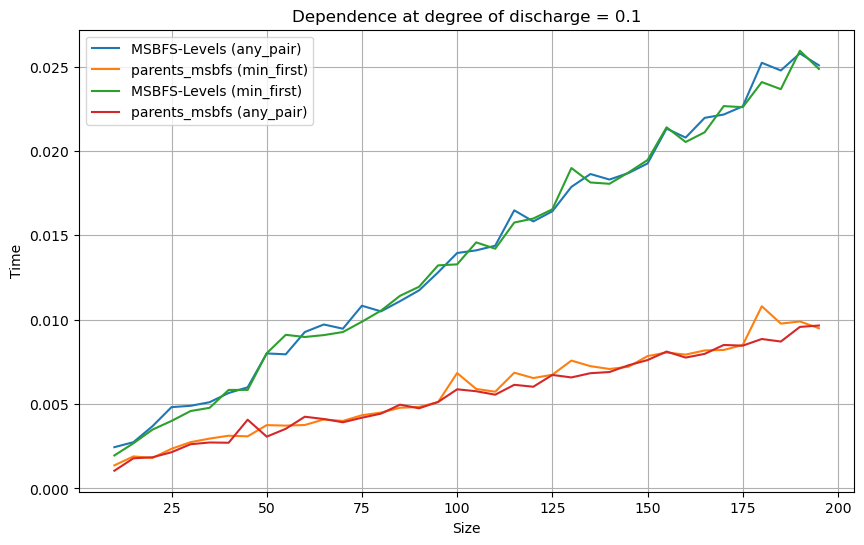

In [18]:
results_random = {}
for num_vertices in np.arange(10, 200, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time_semiring(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time_any_pair = [results_random[count][0] for count in num_vertices_list]
parents_time_min_first = [results_random[count][1] for count in num_vertices_list]
level_time_min_first = [results_random[count][2] for count in num_vertices_list]
parents_time_any_pair = [results_random[count][3] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time_any_pair, label='MSBFS-Levels (any_pair)')
ax.plot(num_vertices_list, parents_time_min_first, label='parents_msbfs (min_first)')
ax.plot(num_vertices_list, level_time_min_first, label='MSBFS-Levels (min_first)')
ax.plot(num_vertices_list, parents_time_any_pair, label='parents_msbfs (any_pair)')

ax.set_xlabel('Size')
ax.set_ylabel('Time')
ax.set_title('Dependence at degree of discharge = 0.1')
ax.legend()
ax.grid(True)
plt.show()

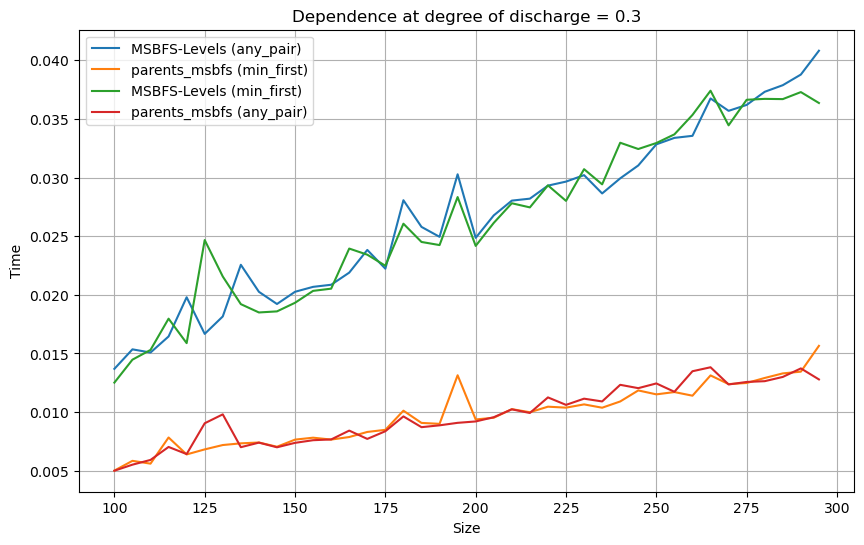

In [19]:
results_random = {}
for num_vertices in np.arange(100, 300, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.3)
    times = calculate_time_semiring(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time_any_pair = [results_random[count][0] for count in num_vertices_list]
parents_time_min_first = [results_random[count][1] for count in num_vertices_list]
level_time_min_first = [results_random[count][2] for count in num_vertices_list]
parents_time_any_pair = [results_random[count][3] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time_any_pair, label='MSBFS-Levels (any_pair)')
ax.plot(num_vertices_list, parents_time_min_first, label='parents_msbfs (min_first)')
ax.plot(num_vertices_list, level_time_min_first, label='MSBFS-Levels (min_first)')
ax.plot(num_vertices_list, parents_time_any_pair, label='parents_msbfs (any_pair)')

ax.set_xlabel('Size')
ax.set_ylabel('Time')
ax.set_title('Dependence at degree of discharge = 0.3')
ax.legend()
ax.grid(True)
plt.show()



Выводы:

Для сгененированных данных различие между разными полукольцами незначительное при различной степени разряженности и для разного размера графа
